In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

In [21]:
df = pd.read_csv('Facebook_Classification_prdiction.csv')

In [22]:
df

,post_type,category,post_month,post_weekday,post_hour,paid,cluster_2
0,Photo,2,12,4,3,0.0,Not-Viral
1,Status,2,12,3,10,0.0,Not-Viral
2,Photo,3,12,3,3,0.0,Not-Viral
3,Photo,2,12,2,10,1.0,Viral
4,Photo,2,12,2,3,0.0,Not-Viral
...,...,...,...,...,...,...,...
491,Photo,3,1,7,2,0.0,Not-Viral
492,Photo,2,1,5,8,0.0,Not-Viral
493,Photo,1,1,5,2,0.0,Not-Viral
494,Photo,3,1,4,11,0.0,Not-Viral


In [23]:
df = df.rename(columns={'cluster_2':'Target'})

In [24]:
df['Target'] = df['Target'].map({'Not-Viral':0,'Viral':1})

#### PreProcess Data
1. Encode `Post Type` and `Category`
2. what should we do with `DateTime Values`
3. We don't have any Scalling Columns For `Classification Prediction`
4. We have To solve Imbalance Data Problem

In [25]:
df

,post_type,category,post_month,post_weekday,post_hour,paid,Target
0,Photo,2,12,4,3,0.0,0
1,Status,2,12,3,10,0.0,0
2,Photo,3,12,3,3,0.0,0
3,Photo,2,12,2,10,1.0,1
4,Photo,2,12,2,3,0.0,0
...,...,...,...,...,...,...,...
491,Photo,3,1,7,2,0.0,0
492,Photo,2,1,5,8,0.0,0
493,Photo,1,1,5,2,0.0,0
494,Photo,3,1,4,11,0.0,0


In [26]:
df.groupby(['paid','Target']).size() # It seems like Paid Isn't the one deciding which post is viral or not

paid  Target
0.0   0         331
      1          27
1.0   0         113
      1          25
dtype: int64

In [27]:
df.groupby(['post_type','Target']).size() # Most of the post that goes Viral are Photos

post_type  Target
Link       0          18
           1           2
Photo      0         376
           1          48
Status     0          44
           1           1
Video      0           6
           1           1
dtype: int64

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [29]:
X = df.drop(columns='Target')
y = df['Target']

In [30]:
neg, pos = y.value_counts()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 8.538461538461538


In [31]:
ct = ColumnTransformer(transformers=[
    ('encoding',OneHotEncoder(handle_unknown='ignore'),['post_type'])],remainder='passthrough')
xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.02,       # Slightly faster to pick up signal
    max_depth=4,              # Increased to 4 to find deeper patterns
    
    # THE REBALANCING:
    scale_pos_weight=4,       # The "Middle Ground" (not 1, not 8.5)
    min_child_weight=7,       # Lowered so it can actually "see" small viral clusters
    reg_lambda=1,             # Standard regularization (lambda=100 was too much)
    
    # STABILITY:
    subsample=0.8,
    colsample_bytree=0.8,
    max_delta_step=1,         # Essential when scale_pos_weight > 1
    
    objective="binary:logistic",
    eval_metric="aucpr",
    random_state=42
)

In [32]:
pipe = make_pipeline(
    ct,xgb)

In [33]:
from sklearn.metrics import classification_report,confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

pipe.fit(X_train, y_train)
y_prob = pipe.predict_proba(X_test)[:, 1]
for t in [0.5, 0.4, 0.3, 0.25, 0.2]: # The lower The Threshold The Higher Model Picks 1
    y_pred = (y_prob >= t).astype(int)
    print(f"\nThreshold: {t}")
    print(classification_report(y_test, y_pred, target_names=["Not-Viral", "Viral"]))



Threshold: 0.5
              precision    recall  f1-score   support

   Not-Viral       0.93      0.93      0.93       111
       Viral       0.38      0.38      0.38        13

    accuracy                           0.87       124
   macro avg       0.66      0.66      0.66       124
weighted avg       0.87      0.87      0.87       124


Threshold: 0.4
              precision    recall  f1-score   support

   Not-Viral       0.94      0.89      0.92       111
       Viral       0.37      0.54      0.44        13

    accuracy                           0.85       124
   macro avg       0.66      0.72      0.68       124
weighted avg       0.88      0.85      0.87       124


Threshold: 0.3
              precision    recall  f1-score   support

   Not-Viral       0.96      0.81      0.88       111
       Viral       0.30      0.69      0.42        13

    accuracy                           0.80       124
   macro avg       0.63      0.75      0.65       124
weighted avg       0.89   

In [34]:
y_pred = (y_prob >= 0.3).astype(int)
print(classification_report(y_test, y_pred, target_names=["Not-Viral", "Viral"]))

              precision    recall  f1-score   support

   Not-Viral       0.96      0.81      0.88       111
       Viral       0.30      0.69      0.42        13

    accuracy                           0.80       124
   macro avg       0.63      0.75      0.65       124
weighted avg       0.89      0.80      0.83       124



In [35]:
confusion_matrix(y_test,y_pred)

array([[90, 21],
       [ 4,  9]])

In [36]:
y_pred_train_logit = pipe.predict_proba(X_train)[:,1]
y_pred_train = (y_pred_train_logit >= 0.3).astype(int)
print(classification_report(y_train, y_pred_train, target_names=["Not-Viral", "Viral"]))

              precision    recall  f1-score   support

   Not-Viral       1.00      0.84      0.91       333
       Viral       0.42      0.97      0.58        39

    accuracy                           0.85       372
   macro avg       0.71      0.91      0.75       372
weighted avg       0.94      0.85      0.88       372



#### We will test it When data is Imbalance To see What will happen

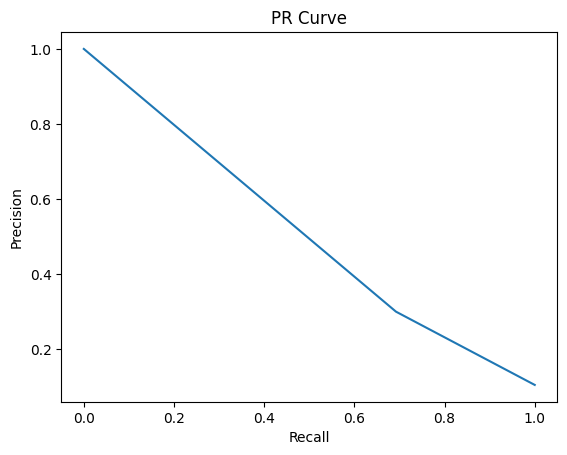

In [37]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.show()
